 All required import statement

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import os
import gc

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

sns.set_theme(style='white', palette='viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output='pandas')
pd.options.mode.chained_assignment = None
seed = 42
tss = TimeSeriesSplit(10)

os.environ['PYTHONHASHSEED'] = '42'

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Prepare the function to read the data

In [2]:
dtypes = {
    'stock_id': np.uint8,
    'date_id': np.uint16,
    'seconds_in_bucket': np.uint16,
    'imbalance_buy_sell_flag': np.int8,
    'time_id': np.uint16,
}


def read_data(data_path: str):
    """Read the data from the train and test csv files, split them into the x (features) and y(target)

    Args:
        data_path (str): absolute save path for the train and test data set 

    Returns:
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        X_test (dataframe): Independent features for testing
    """
    # Load data from the save path
    train = pd.read_csv(f'{data_path}/train.csv',
                        dtype=dtypes).drop(['row_id', 'time_id'], axis=1)
    test = pd.read_csv(f'{data_path}/test.csv',
                       dtype=dtypes).drop(['row_id', 'time_id'], axis=1)

    # Check the data set
    train.info()
    print(train.head())
    print(train.tail())
    gc.collect()

    # split data into X and y
    X = train[~train.target.isna()]
    y = X.pop('target')

    # Test data dont have target column
    X_test = test[~train.target.isna()]

    X.info()
    print(X.head())
    return X, y, X_test

 This section will prepare the cross_validation function
 cv = time series split of 10

In [3]:
def cross_validation(estimator, save_path, X, y, X_test, cv=tss, label=''):
    """cross validation function

    Args:
        estimator (model): chosen model 
        save_path (str) : target directory to save the model
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        X_test (dataframe): Independent features for testing
        cv (split, optional): split for the cross validation. Defaults to tss.
        label (str, optional): special label. Defaults to ''.

    Returns:
        _type_: _description_
    """
    # Build the save path if not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    # train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    best_model = None
    best_model_train_score = 0
    best_val_score = 0
    best_fold = 0

    # training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):

        model = clone(estimator)

        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        # train model
        model.fit(X_train, y_train)

        # Save the model
        joblib.dump(model, f'./{save_path}/{label}_{fold}.model')

        # make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        val_predictions[val_idx] += val_preds

        # evaluate model for a fold
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)

        # Update best model
        if best_val_score == 0 or val_score < best_val_score:
            best_val_score = val_score
            best_model_train_score = train_score
            best_model = model
            best_fold = fold

        # append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)

    # This line print the average
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    for fold in range(len(val_scores)):
        print(f'fold:{fold}, Val Score: {val_scores[fold]}, Train Score: {train_scores[fold]}')
    # Print best model score
    print(
        f'Best validation score: {best_val_score}, associated train score: {best_model_train_score}')
    joblib.dump(best_model, f'./{save_path}/best_model.model')

    return val_scores, val_predictions

 Call the required function and run the model

In [4]:
models = [
    ('LightGBM', LGBMRegressor(random_state=seed, objective='mse', device_type='gpu'))
]
X, y, X_test = read_data(
    "D:/OneDrive/NEU/CS6140/optiver-trading-at-the-close")
model_save_path = "initial_run_raw"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 uint8  
 1   date_id                  uint16 
 2   seconds_in_bucket        uint16 
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int8(1), uint16(2), uint8(1)
memory usage: 469.6 MB
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       1666

<ipython-input-2-a857fca50f6a>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = test[~train.target.isna()]


In [5]:
for (label, model) in models:
    _ = cross_validation(
        make_pipeline(
            model
        ),
        save_path=model_save_path,
        X=X,
        y=y,
        X_test=X_test,
        label=label
    )

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 476172, number of used features: 14
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (7.27 MB) transferred to GPU in 0.009186 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.096914
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 952344, number of used features: 14
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Li

 Explore the model trained
 Job saved is a pipeline, the model is in second step

LGBMRegressor(device_type='gpu', objective='mse', random_state=42)


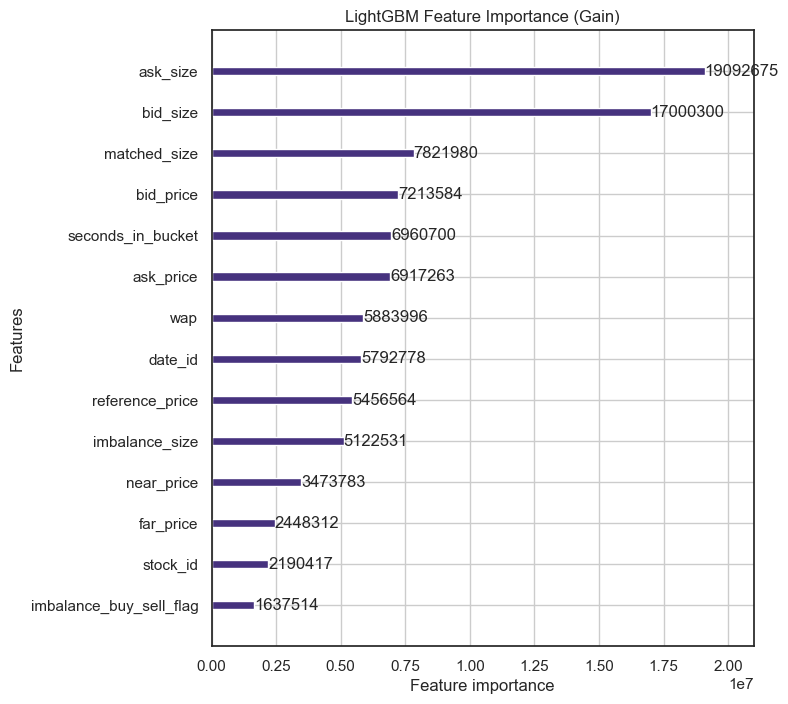

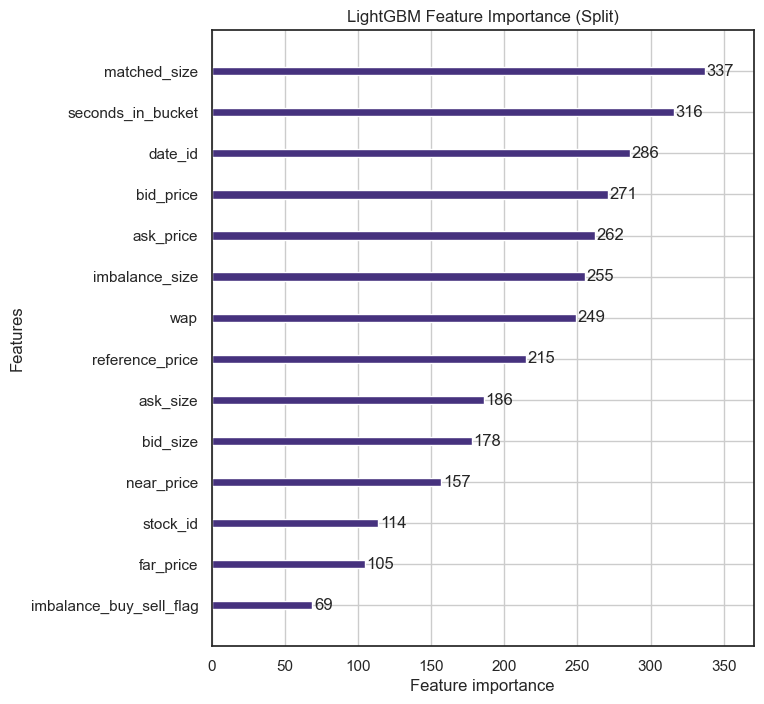

In [6]:
pipeline = joblib.load(f"./{model_save_path}/best_model.model")
trained_model = pipeline[0]
print(trained_model)

lgb.plot_importance(trained_model, importance_type="gain", figsize=(
    7, 8), precision=0, title="LightGBM Feature Importance (Gain)")
plt.show()
lgb.plot_importance(trained_model, importance_type="split", figsize=(
    7, 8), precision=0, title="LightGBM Feature Importance (Split)")
plt.show()